<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/model151.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Download Data for prediction
import pandas as pd
import yfinance as yf
from datetime import datetime, timedelta

# Machine Learning Libraries
from sklearn.model_selection import train_test_split, GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# For saving the model
import joblib


# Get today's date and date one year ago
#today = '2024-09-27'
one_year_ago = '2024-05-01'
# Format dates
#today_str = today
one_year_ago_str = one_year_ago

# List of Nifty 50 tickers with '.NS' suffix for NSE stocks
nifty50_tickers = [
    'RELIANCE.NS', 'TCS.NS', 'HDFCBANK.NS', 'INFY.NS', 'ICICIBANK.NS',
    'HINDUNILVR.NS', 'HDFC.NS', 'KOTAKBANK.NS', 'ITC.NS', 'LT.NS',
    'SBIN.NS', 'BHARTIARTL.NS', 'ASIANPAINT.NS', 'AXISBANK.NS', 'BAJFINANCE.NS',
    'DMART.NS', 'MARUTI.NS', 'HCLTECH.NS', 'SUNPHARMA.NS', 'ULTRACEMCO.NS',
    'MM.NS', 'TECHM.NS', 'NTPC.NS', 'POWERGRID.NS', 'WIPRO.NS',
    'NESTLEIND.NS', 'INDUSINDBK.NS', 'BAJAJFINSV.NS', 'ADANIPORTS.NS', 'ONGC.NS',
    'TATASTEEL.NS', 'TITAN.NS', 'COALINDIA.NS', 'BAJAJ-AUTO.NS', 'JSWSTEEL.NS',
    'DIVISLAB.NS', 'HDFCLIFE.NS', 'DRREDDY.NS', 'BPCL.NS', 'GRASIM.NS',
    'EICHERMOT.NS', 'BRITANNIA.NS', 'CIPLA.NS', 'HEROMOTOCO.NS', 'SBILIFE.NS',
    'SHREECEM.NS', 'TATAMOTORS.NS', 'IOC.NS', 'UPL.NS', 'GAIL.NS','^NSEI',
]

# Fetch data for the past one year
data = yf.download(
    tickers=nifty50_tickers,
    start=one_year_ago_str,
    interval='1d',
    group_by='ticker',
    auto_adjust=True
)

# Initialize an empty DataFrame to store percentage changes
pct_change_df = pd.DataFrame()

for ticker in nifty50_tickers:
    try:
        # Get the closing prices
        close_prices = data[ticker]['Close']
        # Calculate daily percentage change
        daily_pct_change = close_prices.pct_change(5) * 100
        # Create a DataFrame with Date and Daily Percentage Change
        temp_df = pd.DataFrame({
            'Date': daily_pct_change.index,
            'Ticker': ticker.replace('.NS', ''),
            'Daily Change (%)': daily_pct_change.values
        })
        # Append to the main DataFrame
        pct_change_df = pd.concat([pct_change_df, temp_df], ignore_index=True)
    except Exception as e:
        print(f"Could not process {ticker}: {e}")

# Pivot the DataFrame to have dates as index and tickers as columns
pivot_df = pct_change_df.pivot(index='Date', columns='Ticker', values='Daily Change (%)')
# Sort the DataFrame by Date
pivot_df = pivot_df.sort_index()
pivot_df['^NSEI']=pivot_df['^NSEI'].shift(-1)
# Save to CSV
pivot_df.to_csv('nifty50_daily_change.csv')

print("Daily percentage changes saved to 'nifty50_daily_change.csv'")


[*********************100%***********************]  51 of 51 completed
ERROR:yfinance:
2 Failed downloads:
ERROR:yfinance:['MM.NS', 'HDFC.NS']: YFTzMissingError('$%ticker%: possibly delisted; no timezone found')
<ipython-input-1-f1bfb6f74e29>:59: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_pct_change = close_prices.pct_change(5) * 100


Daily percentage changes saved to 'nifty50_daily_change.csv'


In [2]:
data= pd.read_csv('nifty50_daily_change.csv')
data_copy_=data["^NSEI"]
# Drop the original '^NSEI' column
data.drop('^NSEI', axis=1, inplace=True)

# Feature Engineering: Create lag features
feature_cols = [col for col in data.columns if col not in ['Date', 'Target']]

# Define X and y
X = data[feature_cols]

In [3]:
!wget https://raw.githubusercontent.com/anirbanghoshsbi/data/main/voting_classifier_model.pkl -O voting_classifier_model.pkl


--2024-10-13 09:04:23--  https://raw.githubusercontent.com/anirbanghoshsbi/data/main/voting_classifier_model.pkl
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4526255 (4.3M) [application/octet-stream]
Saving to: ‘voting_classifier_model.pkl’

voting_classifier_m 100%[===================>]   4.32M  --.-KB/s    in 0.04s   

2024-10-13 09:04:23 (112 MB/s) - ‘voting_classifier_model.pkl’ saved [4526255/4526255]



In [4]:
# Load the model for future use (if needed)
voting_clf_loaded = joblib.load('voting_classifier_model.pkl')


In [5]:
# make predictions
predictions=voting_clf_loaded.predict(X.fillna(0))

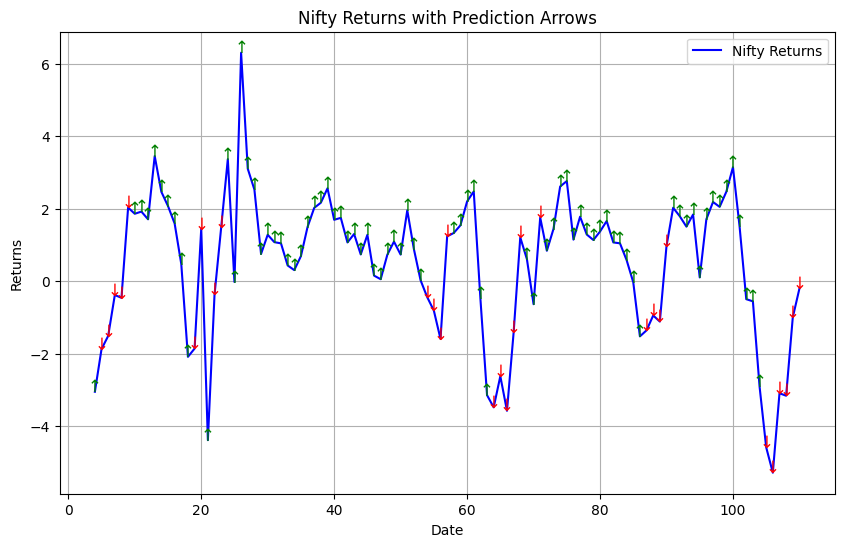

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example data
# Assuming data_copy_ is a pandas Series containing Nifty returns
# data_copy_ = pd.Series(...)
# predictions = np.array(...)

# Creating a date index for plotting purposes
data_copy_ = data_copy_.reset_index()

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot Nifty returns (data_copy_)
plt.plot(data_copy_['index'], data_copy_[data_copy_.columns[1]], label='Nifty Returns', color='blue')

# Plot up and down arrows based on predictions (1 = Up, 0 = Down)
for i in range(len(predictions)):
    if predictions[i] == 1:
        # Up arrow
        plt.annotate('↑', (data_copy_['index'][i], data_copy_[data_copy_.columns[1]][i]), color='green', fontsize=12, ha='center')
    else:
        # Down arrow
        plt.annotate('↓', (data_copy_['index'][i], data_copy_[data_copy_.columns[1]][i]), color='red', fontsize=12, ha='center')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Returns')
plt.title('Nifty Returns with Prediction Arrows')
plt.legend()

# Show the plot
plt.grid(True)
plt.show()


[*********************100%***********************]  1 of 1 completed


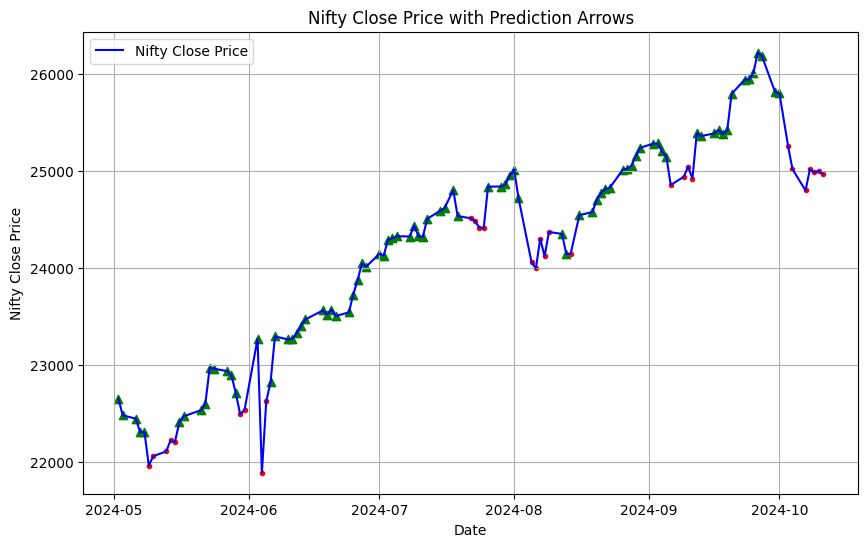

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Example data
# Assuming data['^NSEI'] is a pandas DataFrame downloaded from yfinance with 'Close' column
# Assuming predictions is a numpy array with 1 (up) and 0 (down)
# predictions = np.array(...)
# data['^NSEI'] = pd.DataFrame(...)
data_nsei=yf.download('^NSEI',start='2024-05-01')
# Extract the close prices
nifty_close = data_nsei['Close']

# Reset the index for plotting purposes
nifty_close = nifty_close.reset_index()

# Initialize the plot
plt.figure(figsize=(10, 6))

# Plot Nifty Close prices
plt.plot(nifty_close['Date'], nifty_close['Close'], label='Nifty Close Price', color='blue')
preds = predictions[-len(nifty_close):]

# Overlay predictions (1 = Up, 0 = Down) as arrows
for i in range(len(preds)):
    if preds[i] == 1:
        # Up arrow
        plt.scatter(nifty_close['Date'][i], nifty_close['Close'][i],marker='^', color='green')
    else:
        # Down arrow
        plt.scatter(nifty_close['Date'][i], nifty_close['Close'][i],marker='.', color='red')

# Add labels and title
plt.xlabel('Date')
plt.ylabel('Nifty Close Price')
plt.title('Nifty Close Price with Prediction Arrows')
plt.legend()

# Display the grid and plot
plt.grid(True)
plt.show()
